In [61]:
import sys
sys.path.append('..')

from src.pdfs_numba_stats import SignalBackgroundModel
from scipy import integrate
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('mystyle.mplstyle')
np.random.seed(42)

In [62]:
# Parameters
signal_params = {
    'mu': 3, 
    'sigma': 0.3, 
    'beta': 1, 
    'm': 1.4, 
    'decay_rate': 0.3
}
background_params = {
    'mu_bg': 0, 
    'sigma_bg': 2.5
}
f = 0.6  # Signal fraction
x_min, x_max = 0.0, 5.0
y_min, y_max = 0.0, 10.0

# Create model
model = SignalBackgroundModel(*signal_params.values(), *background_params.values(), f, x_min, x_max, y_min, y_max)

## Verify Normalization

- **Signal**:  
  $ g_s(X) $ is the Crystal Ball function over $ X $,  
  $ h_s(Y) = \lambda e^{-\lambda Y} $ (an exponential decay with decay constant $ \lambda $).

- **Background**:  
  $ g_b(X) $ is uniform,  
  $ h_b(Y) $ is a truncated normal with mean $ \mu_b $ and width $ \sigma_b $.

$$
f(X, Y) = f g_s(X)h_s(Y) + (1 - f)g_b(X)h_b(Y).
$$

We want to verify that the normalization of functions below:
- $ g_s(X) $ over $ X \in [0, 5] $
- $ g_b(X) $ over $ X \in [0, 5] $
- $ h_s(Y) $ over $ Y \in [0, 10] $
- $ h_b(Y) $ over $ Y \in [0, 10] $
- $ s(X, Y) = g_s(X)h_s(Y) $ over $ X \in [0, 5] $ and $ Y \in [0, 10] $
- $ b(X, Y) = g_b(X)h_b(Y) $ over $ X \in [0, 5] $ and $ Y \in [0, 10] $
- $ f(X, Y) = f g_s(X)h_s(Y) + (1 - f)g_b(X)h_b(Y) $ over $ X \in [0, 5] $ and $ Y \in [0, 10] $

is 1.


In [63]:
def verify_normalization_1d(model, x_min, x_max):
    pdf_func = lambda x: model.truncated_pdf(x)
    normalization = integrate.quad(pdf_func, x_min, x_max)[0]
    return normalization

def verify_normalization_2d(pdf_func, x_min, x_max, y_min, y_max):
    normalization = integrate.dblquad(pdf_func, y_min, y_max, lambda _: x_min, lambda _: x_max)[0]
    return normalization

# Calculate all normalizations
norm_1d = {
    "Signal X distribution": verify_normalization_1d(model.signal_x, x_min, x_max),
    "Background X distribution": verify_normalization_1d(model.background_x, x_min, x_max),
    "Signal Y distribution": verify_normalization_1d(model.signal_y, y_min, y_max),
    "Background Y distribution": verify_normalization_1d(model.background_y, y_min, y_max)
}

norm_2d = {
    "Total distribution": model.verify_normalization(),
    "Signal XY distribution": verify_normalization_2d(model.signal_xy, x_min, x_max, y_min, y_max),
    "Background XY distribution": verify_normalization_2d(model.background_xy, x_min, x_max, y_min, y_max)
}

# Print formatted results
print("1D Normalizations:")
for name, value in norm_1d.items():
    print(f"- {name:<30} {value:.3f}")

print("\n2D Normalizations:")
for name, value in norm_2d.items():
    print(f"- {name:<30} {value:.3f}")

1D Normalizations:
- Signal X distribution          1.000
- Background X distribution      1.000
- Signal Y distribution          1.000
- Background Y distribution      1.000

2D Normalizations:
- Total distribution             1.000
- Signal XY distribution         1.000
- Background XY distribution     1.000


## Visualization

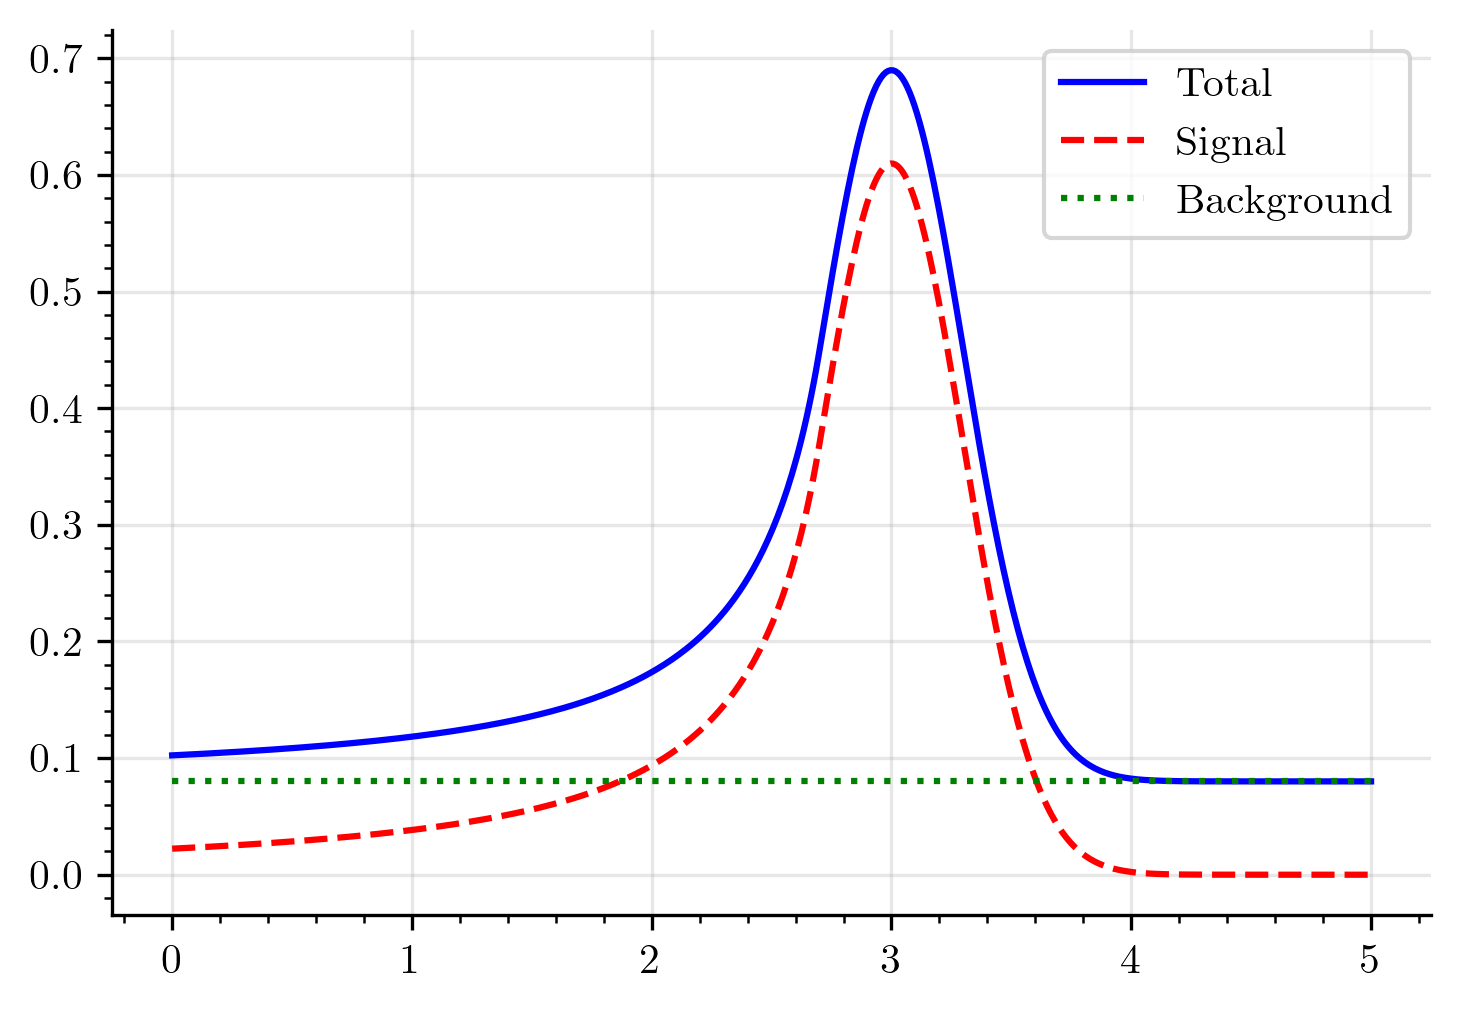

In [64]:
# Vectorize the pdfs (if use scipy.stats implemented pdfs)
# vec_signal_x_pdf = np.vectorize(model.signal_x.truncated_pdf)           # g_s(X) [0, 5]
# vec_background_x_pdf = np.vectorize(model.background_x.truncated_pdf)   # g_b(X) [0, 5]
# vec_signal_y_pdf = np.vectorize(model.signal_y.truncated_pdf)           # h_s(Y) [0, 10]
# vec_background_y_pdf = np.vectorize(model.background_y.truncated_pdf)   # h_b(Y) [0, 10]
# vec_fxy_pdf = np.vectorize(model.pdf)                                # f(X, Y) [0, 5] x [0, 10]

# Get the truncated pdf methods (these only take x, y as arguments)
signal_x_pdf = model.signal_x.truncated_pdf
background_x_pdf = model.background_x.truncated_pdf
signal_y_pdf = model.signal_y.truncated_pdf
background_y_pdf = model.background_y.truncated_pdf
fxy_pdf = model.pdf

# Define grid for plotting
x_vals = np.linspace(x_min, x_max, 500)
y_vals = np.linspace(y_min, y_max, 500)

# Calculate marginal distributions
signal_x_marginal = f * signal_x_pdf(x_vals)
background_x_marginal = (1 - f) * background_x_pdf(x_vals)
f_x_marginal = signal_x_marginal + background_x_marginal
#
signal_y_marginal = f * signal_y_pdf(y_vals)
background_y_marginal = (1 - f) * background_y_pdf(y_vals)
f_y_marginal = signal_y_marginal + background_y_marginal

# Plot
plt.figure()
plt.plot(x_vals, f_x_marginal, 'b-', label='Total')
plt.plot(x_vals, signal_x_marginal, 'r--', label='Signal')
plt.plot(x_vals, background_x_marginal, 'g:', label='Background')
plt.legend()
plt.tight_layout()
plt.savefig('../report/images/marginal_x.pdf', bbox_inches='tight')
plt.show()

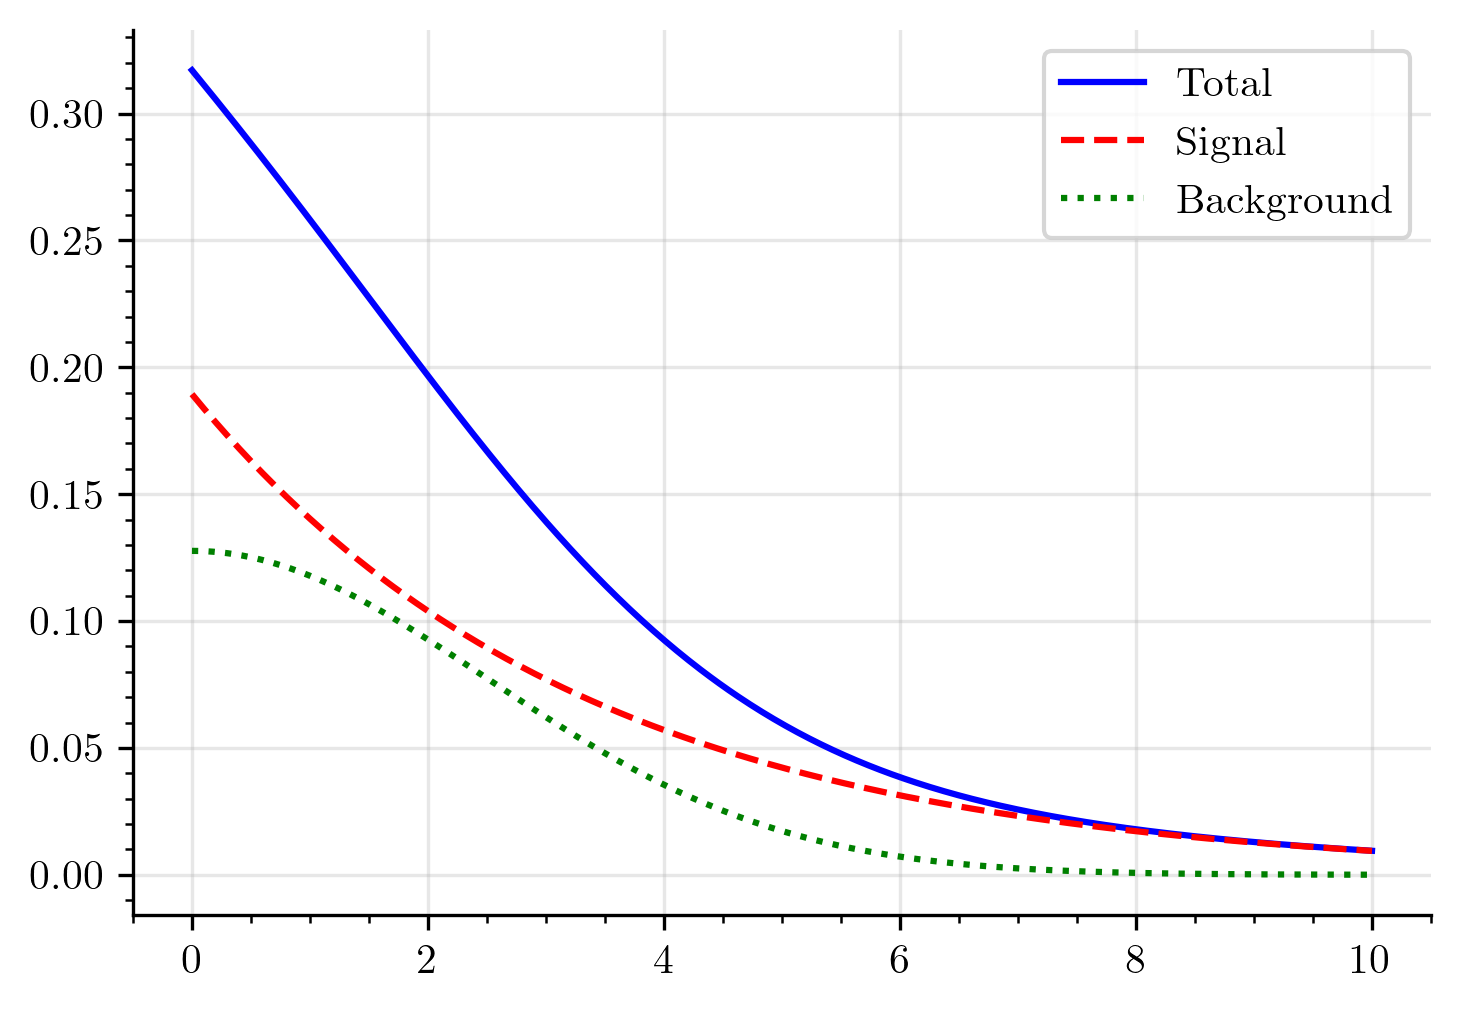

In [65]:
plt.figure()
plt.plot(y_vals, f_y_marginal, 'b-', label='Total')
plt.plot(y_vals, signal_y_marginal, 'r--', label='Signal')
plt.plot(y_vals, background_y_marginal, 'g:', label='Background')
plt.legend()
plt.tight_layout()
plt.savefig('../report/images/marginal_y.pdf', bbox_inches='tight')
plt.show()

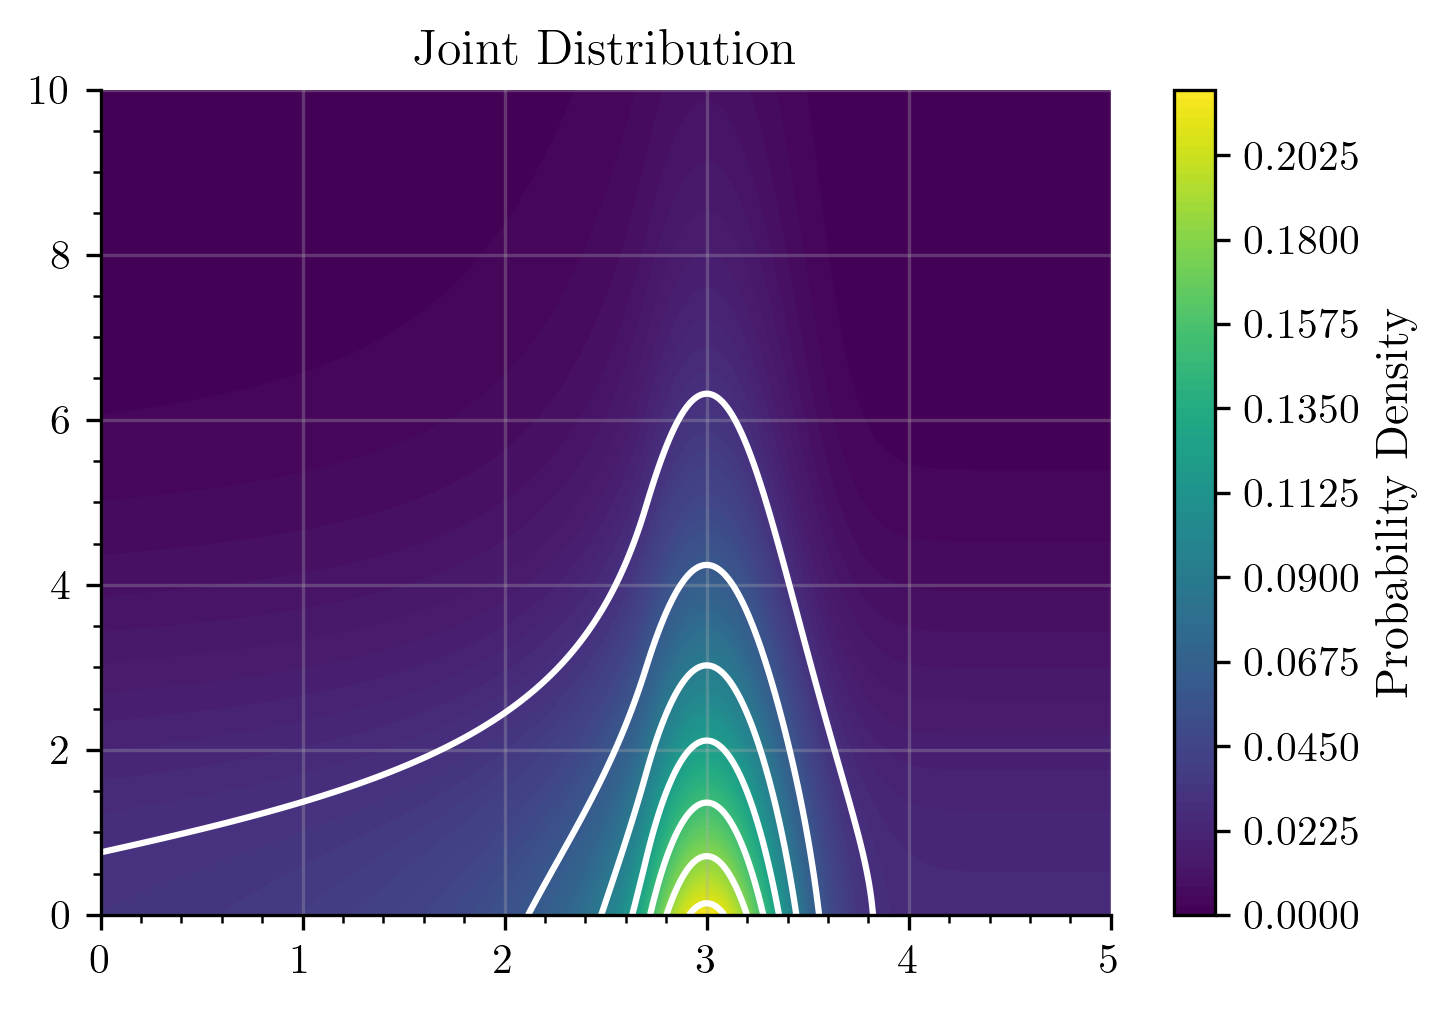

In [66]:
# Joint distribution
x_grid, y_grid = np.meshgrid(x_vals, y_vals)
z = fxy_pdf(x_grid, y_grid)
plt.figure()
plt.title('Joint Distribution')
plt.contour(x_grid, y_grid, z, colors='white')
plt.contourf(x_grid, y_grid, z, levels=100)
plt.colorbar(label='Probability Density')
plt.tight_layout()
plt.savefig('../report/images/joint_distribution.pdf', bbox_inches='tight')
plt.show()